In [191]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage.morphology
import skimage.measure
import skimage.segmentation
import skimage.feature
import sklearn.preprocessing
import imageio
import glob
import cv2
from scipy.spatial import distance as dist
import pyefd
import math
import sklearn.decomposition

Images/depth/usable\6.tiff


(-0.5, 1279.5, 719.5, -0.5)

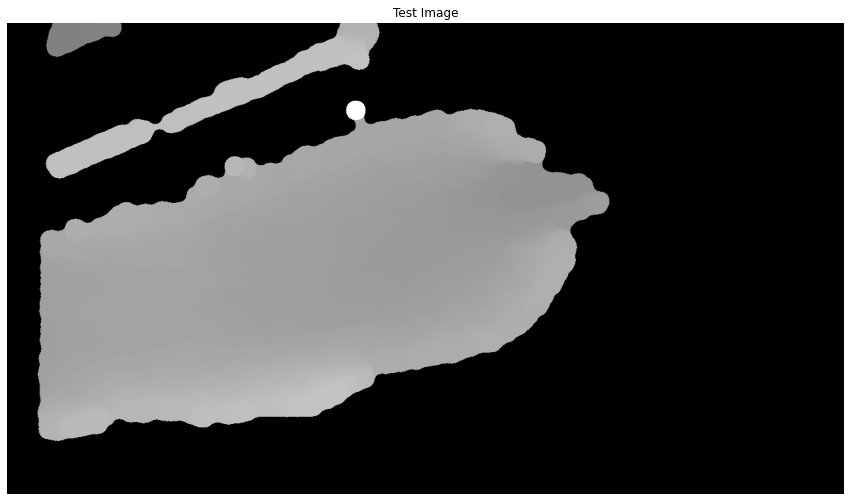

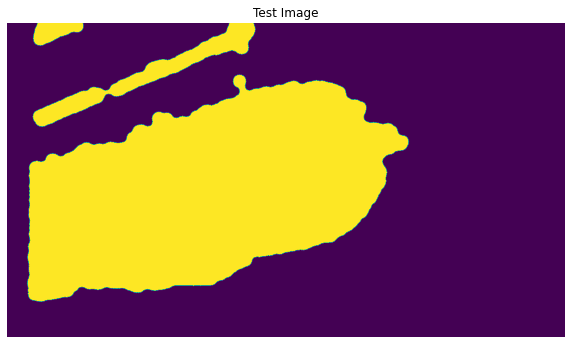

In [192]:
#inputs---------------------------------

img_num = 5
img_names = glob.glob('Images/depth/usable/*')
img = imageio.imread(img_names[img_num])

print(img_names[img_num])

if np.shape(np.shape(img))[0] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# scale_file = open("Images/depth_scale.txt", "r")
# depth_scale = float(scale_file.readlines()[0][0:5])

#functions-----------------------------
max_dist = np.max(img)
min_dist = np.min(img)
#img_post = np.where((img>min_dist-100) & (img<max_dist-400), img, 0)

otsu_thresh = skimage.filters.threshold_otsu(img)
img_post = np.where(img< otsu_thresh, img, 0)
img_post = skimage.morphology.remove_small_objects(img_post, 64)
img_post = skimage.morphology.opening(img_post, skimage.morphology.disk(15))
img_post = skimage.morphology.closing(img_post, skimage.morphology.disk(10))
# otsu_thresh = skimage.filters.threshold_otsu(img_post)
# print(otsu_thresh)
# img_post = np.where(img_post< otsu_thresh, img_post, 0)




img_mask = np.where(img_post != 0, 1, 0)

plt.figure(figsize=(15,15))
plt.imshow(img_post, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.figure(figsize=(10,10))
plt.imshow(img_mask)
plt.title("Test Image")
plt.axis('off')

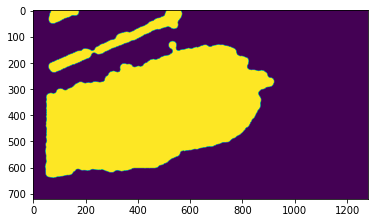

In [193]:
plt.imshow(img_mask)

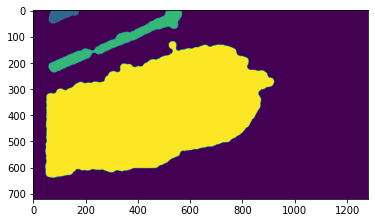

In [194]:
#Segmentation for FD

img_seg = skimage.measure.label(img_mask, background = 0, connectivity=2)
#img_seg = skimage.measure.label(skimage.segmentation.slic(img_post, n_segments = 10,  compactness=0.01, sigma = 5))
plt.imshow(img_seg)

294291


(-0.5, 1279.5, 719.5, -0.5)

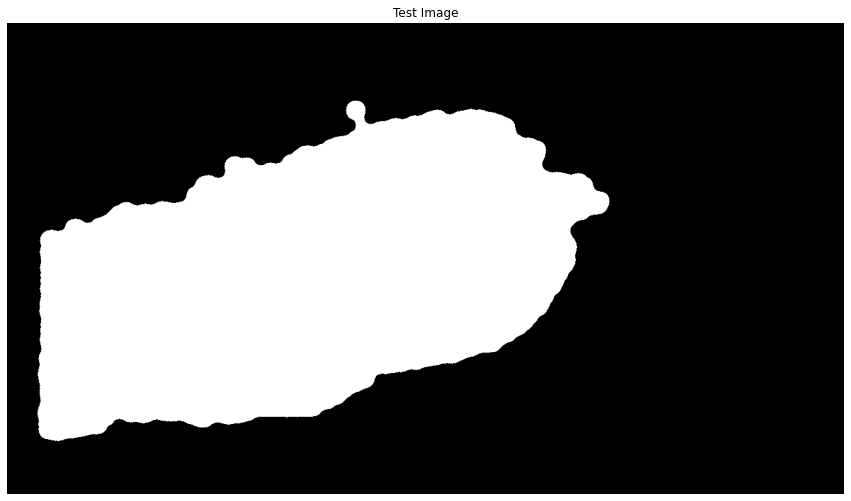

In [195]:
max_size = 0
layer = []
for i in range(1, np.max(img_seg)+1):
    max_temp = np.sum(np.where(img_seg == i, 1, 0))
    if max_temp > max_size:
        max_size = max_temp
        layer.append(i)

print(max_size)

largest_seg = np.where(img_seg == layer[-1], True, False)
plt.figure(figsize=(15,15))
plt.imshow(largest_seg, cmap='gray')
plt.title("Test Image")
plt.axis('off')
# total = skimage.segmentation.chan_vese(img_post*largest_seg, mu = 0.5) #Consider using osmehting faster from OpenCV
# plt.contour(total)

In [196]:
#------Rotation from OpenCV tutorial-----------

from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from math import atan2, cos, sin, sqrt, pi
def drawAxis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
#     # create the arrow hooks
#     p[0] = q[0] + 9 * cos(angle + pi / 4)
#     p[1] = q[1] + 9 * sin(angle + pi / 4)
#     cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
#     p[0] = q[0] + 9 * cos(angle - pi / 4)
#     p[1] = q[1] + 9 * sin(angle - pi / 4)
#     cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
    

    
def getOrientation(pts, img):
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
#     drawAxis(img, cntr, p1, (255, 0, 0), 1)
#     drawAxis(img, cntr, p2, (255, 0, 0), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle


# src = cv.imread('Images/RGB/4_Angus/4.tiff')
# # Check if image is loaded successfully
# if src is None:
#     print('Could not open or find the image: ', args.input)
#     exit(0)
# cv.imshow('src', src)
# # Convert image to grayscale
# gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# # Convert image to binary
# _, bw = cv.threshold(gray, 0, 50, cv.THRESH_BINARY | cv.THRESH_OTSU)
# bw = np.where(largest_seg==True, 1, 0)

# contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

cow_mask = np.where(largest_seg == True, 255, 0).astype('uint8') #changed 255 to 1
src = cow_mask
contours, _ = cv.findContours(src, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
#cv.imshow('src', src)
for i, c in enumerate(contours):
#     Calculate the area of each contour
#     area = cv.contourArea(c)
#     # Ignore contours that are too small or too large
#     if area < 1e2 or 1e5 < area:
#         continue
#     Draw each contour only for visualisation purposes
    cv.drawContours(src, contours, i, (0, 0, 255), 2)
#     Find the orientation of each shape
    angle = getOrientation(c, src)
    angle = np.rad2deg(angle)-90
    if angle < -180:
        angle = angle+180
#cv.imshow('Orientation Lines', src)

# cnt = max(contours, key=cv2.contourArea)
# cv.drawContours(src, cnt, -1, (0, 0, 255), 2)
# angle = np.rad2deg(getOrientation(cnt, src))-90

print(angle)
image_center = tuple(np.array(cow_mask.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
rotated_cow = cv2.warpAffine(cow_mask, rot_mat, cow_mask.shape[1::-1], flags=cv2.INTER_LINEAR)

#cv.imshow('result', rotated_cow)

k = cv.waitKey(0)
if k == '27':
    cv2.destroyAllWindows()

# contours, _ = cv.findContours(rotated_cow, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
# max_cnt = max(contours, key=cv2.contourArea)
# angle = getOrientation(max_cnt, rotated_cow)
# print(np.rad2deg(angle))

-108.31602232203885


27
(1, 1978, 1, 2)
27 653
(1, 1938, 1, 2)


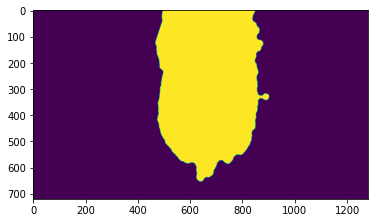

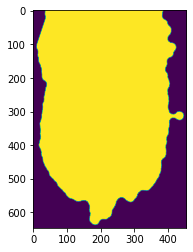

In [197]:
# cv2.drawContours(rotated_cow, max_cnt, -1, (128, 0, 0), 3)
# cv2.imshow('contours', rotated_cow)
# cv2.waitKey(0)

plt.figure()
plt.imshow(rotated_cow)

for i in range(np.shape(cow_mask)[0]):
    if np.sum(cow_mask[i, :]) != 0:
        len_top_row = int(np.sum(cow_mask[i, :])/255)
        break
#print(len_top_row)
crop_length = abs(int(len_top_row*np.tan(abs(np.deg2rad(angle)))))
print(crop_length)
# max_y = np.max(np.where(rotated_cow == 255)[0])
# min_y = np.min(np.where(rotated_cow == 255)[0])


# max_x = np.max(np.where(rotated_cow == 255)[1])
# min_x = np.min(np.where(rotated_cow == 255)[1])

#-------------------------------------------------Consider finding the maximums and minimums using sums

# temp_crop = rotated_cow[crop_length:, :]
# plt.figure()
# plt.imshow(temp_crop)


# row_sums = np.sum(temp_crop, axis=0)
# column_sums = np.sum(temp_crop, axis = 1)
# max_row = np.where(row_sums == np.max(row_sums))
# max_column = np.where(column_sums == np.max(column_sums))



# print(max_row)

cnt, _ = cv2.findContours(rotated_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print(np.shape(cnt))
max_cnt = max(cnt, key=cv2.contourArea)


reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

max_y_crop = np.max(reshaped_contour[::, 0])
min_y_crop = np.min(reshaped_contour[::, 0])


max_x_crop = np.max(reshaped_contour[::, 1])
# min_x_crop = np.min(reshaped_contour[::, 1]) #needs to be fixed somehow------------------------------------------
min_x_crop = crop_length

print(min_x_crop, max_x_crop)
if min_x_crop > 10:
    cropped_cow = rotated_cow[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
if min_x_crop < 10:
    cropped_cow = rotated_cow[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]
cnt, _ = cv2.findContours(cropped_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print(np.shape(cnt))
max_cnt = max(cnt, key=cv2.contourArea)
reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

# img_seg = max(skimage.measure.label(np.where(cropped_cow != 0, 255, 0), background = 0, connectivity=2), key=np.sum())
# plt.figure()
# plt.imshow(img_seg)

plt.figure()
plt.imshow(cropped_cow)
b_cow = np.where(cropped_cow>0, 1, 0)

653 27 902 467


(-11.505555555555558, 466.5055555555556, -31.79444444444445, 667.6833333333335)

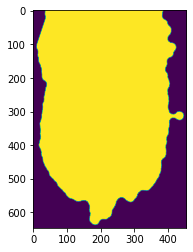

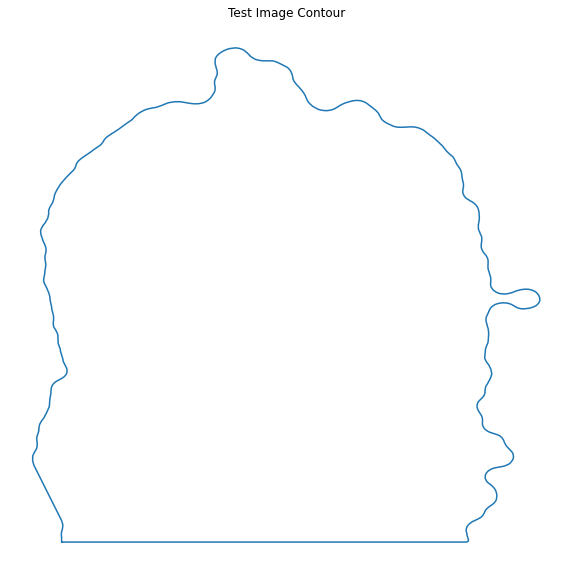

In [198]:
#------------------------Getting contour----------------------------------------------------------------
print(max_x_crop, min_x_crop, max_y_crop, min_y_crop)



plt.figure()
plt.plot(reshaped_contour[:,0]-min_y_crop, reshaped_contour[:,1]-min_x_crop)
plt.imshow(cropped_cow)



smoothed_contour = scipy.signal.savgol_filter((reshaped_contour[:,0], reshaped_contour[:,1]), 9, 1, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0).T
# print(np.shape(normalized_contour))
plt.figure(figsize=(10,10))
plt.plot(smoothed_contour[:,0], smoothed_contour[:,1])
plt.title('Test Image Contour')
plt.axis('off')

#plt.imshow(img_cropped)

[[-36471399.08164233]
 [-34707439.81575456]
 [-31598320.58312682]
 [-26969771.70973324]
 [-19576174.03300491]
 [ -8404730.47680342]
 [ -4215423.10709695]
 [  4533705.75887365]
 [ 21645130.85301084]
 [ 40941904.21968629]
 [ 47571453.06428221]
 [ 45092446.12147665]
 [ 63467928.24264516]
 [ 56485327.40774126]
 [ 33034055.63247468]
 [ 17180518.19332431]
 [  -401990.4504229 ]
 [-14394698.84411601]
 [-22810753.21309667]
 [-28562057.11429669]
 [-32207808.58646332]
 [-34415972.83059042]
 [-35215929.64736685]] ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22']
(23, 1)


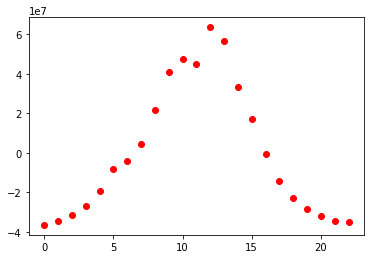

In [199]:
#----------------------Getting Kernel PCA---------------------------------
#The contour is messed up because the image is cropped too much to use the skimage function
def extract_kernel_PCA(mask, points):
    B=skimage.measure.find_contours(mask,0.5,'high')[0]
    #print(np.shape(B))
    factor = int(np.shape(B)[0]/points)
    rem = np.shape(B)[0]%factor
    len_B = np.shape(B)[0]
    
    B_23 = np.zeros((points, 2))
    #print(B)
    #print(B_23)
    #print(np.shape(B_23))
    B_23[:, 0] = B[0:(len_B-rem):factor, 0]
    B_23[:, 1] = B[0:(len_B-rem):factor, 1]
    #print(B_23)
    kpca = sklearn.decomposition.KernelPCA(n_components = 1, kernel = 'poly')
    f = kpca.fit_transform(B_23)
    fnames = []
    for i in range(0, points):
        fnames.append(f'PCA_{i}')

    
    return f, fnames

f, fnames = extract_kernel_PCA(b_cow, 23)
print(f, fnames)
print(np.shape(f))

plt.figure()
#plt.plot(f[:, 0], f[:, 1], 'bo')
plt.plot(f, 'ro')

255


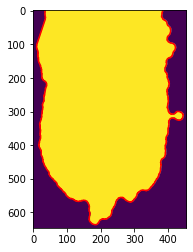

In [200]:
B=skimage.measure.find_contours(b_cow,0.8,'high')[0]
print(np.max(cropped_cow))
plt.plot(B[:, 1], B[:, 0], 'red')
plt.imshow(cropped_cow)

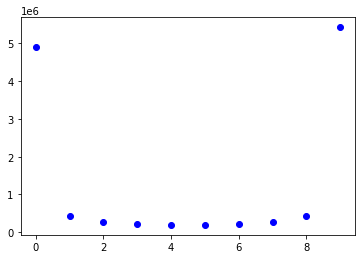

In [201]:
#------------------------Getting fourier descriptors-----------------------

def extract_boundary_features(mask):
  f = np.arange(0, 10)
  fnames = []
  fnames.append('Fourier_desc_a0')
  fnames.append('Fourier_desc_a1')
  fnames.append('Fourier_desc_a2')
  fnames.append('Fourier_desc_a3')
  fnames.append('Fourier_desc_a4')
  fnames.append('Fourier_desc_a5')
  fnames.append('Fourier_desc_a6')
  fnames.append('Fourier_desc_a7')
  fnames.append('Fourier_desc_a8')
  fnames.append('Fourier_desc_a9')

  B=skimage.measure.find_contours(mask,0.5,'high')[0]

  s = np.zeros(np.shape(B)[0], dtype=complex)
  for k in range(np.shape(B)[0]):
    s[k] = float(B[k][0]) + float(B[k][1])*1j
  
  S = scipy.fft.fft(s, n=10000)
  # print(s[1])
  # print(type(s[1]))
  for k in range(0,10):
    f[k] = np.abs(S[k*1000:(k+1)*1000].sum())
  return f, fnames


FD, fnames = extract_boundary_features(b_cow)

plt.figure()
plt.plot(FD, 'bo')

In [202]:
#----Hu Moments--------
# plt.imshow(skimage.measure.label(np.where(cropped_cow>0, 1, 0)))

def Hu_moments(mask):
    props = skimage.measure.regionprops(np.where(mask>0, 1, 0), cache=True)
    fnames = ['phi1', 'phi2', 'phi3', 'phi4', 'phi5', 'phi6', 'phi7']
    f = props[0].moments_hu
    return f, fnames


# print(props[0].centroid)
# plt.plot(props[0].centroid[1], props[0].centroid[0], 'bo')

# print(props[0].moments_hu)


f, fnames = Hu_moments(b_cow)
print(f)

[1.79686652e-01 5.34110176e-03 1.43958768e-04 2.05550588e-06
 2.77993456e-11 1.28855234e-07 2.18503770e-11]


In [203]:
def regionprops_features(mask):
  props = skimage.measure.regionprops(mask.astype(int))
  fnames = ['area', 'convex_area', 'eccentricity','equivalent_diameter', 'euler_number', 'extent', 'filled_area','major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']
  f = [props[0]['area'], props[0]['convex_area'], props[0]['eccentricity'], props[0]['equivalent_diameter'], props[0]['euler_number'], props[0]['extent'], props[0]['filled_area'],
       props[0]['major_axis_length'], props[0]['minor_axis_length'], props[0]['perimeter'], props[0]['solidity']]
  return f, fnames

f, fnames = regionprops_features(b_cow)
print(f, fnames)

[206926, 224385, 0.7604319954730153, 513.2897486156023, 1, 0.7450563852922961, 206926, 646.8667882934177, 420.08665778525625, 2221.1149698820104, 0.9221917686119838] ['area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity']


In [204]:
#-------Anatomical Landmarks---------
#-------Rotate Source Image----------

depth = imageio.imread(img_names[img_num])
rotated_depth = cv2.warpAffine(depth, rot_mat, depth.shape[1::-1], flags=cv2.INTER_LINEAR)

if min_x_crop > 10:
    cropped_depth = rotated_depth[min_x_crop-10:max_x_crop+10, min_y_crop-10:max_y_crop+10]
if min_x_crop < 10:
    cropped_depth = rotated_depth[min_x_crop:max_x_crop+10, min_y_crop-10:max_y_crop+10]

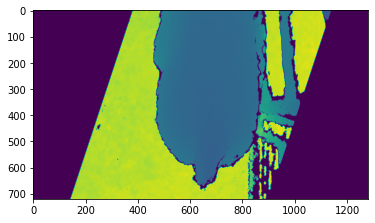

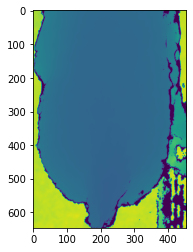

In [205]:
plt.figure()
plt.imshow(rotated_depth)

plt.figure()
plt.imshow(cropped_depth)

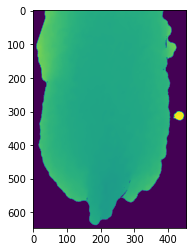

In [206]:
masked_depth = (b_cow*cropped_depth).astype('uint16')

plt.imshow(masked_depth)
length_depth, width_depth = np.shape(masked_depth)

(array([428], dtype=int64),)


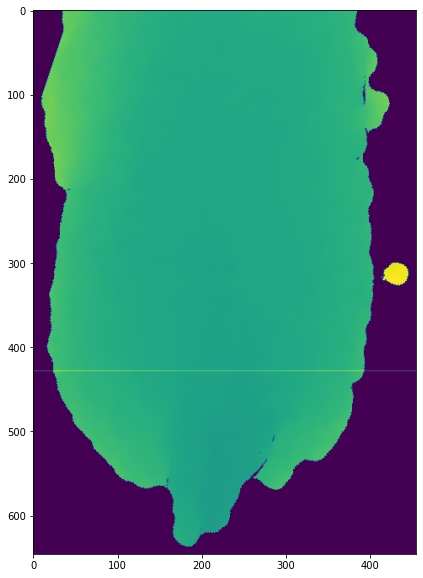

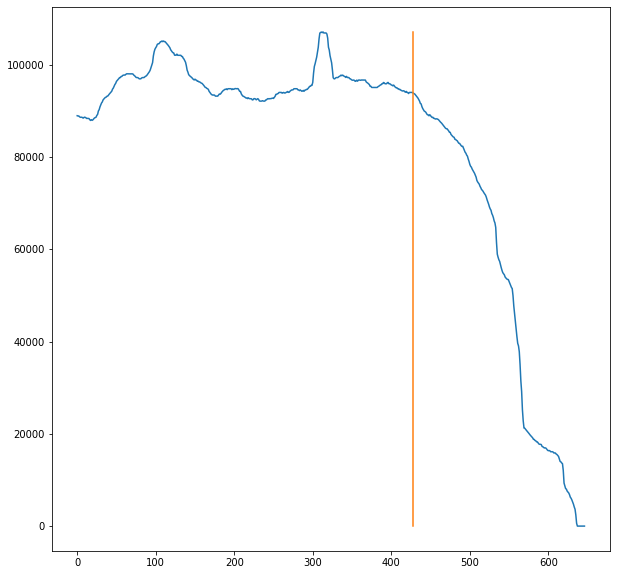

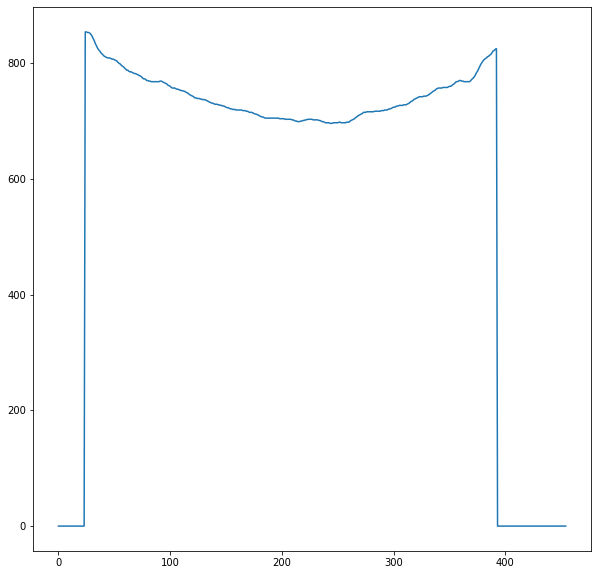

In [207]:
#Scanning the body to locate the hips

row_sums = np.sum(cropped_cow, axis=1)
if (len(row_sums)%2 == 0):
    row_sums = np.append(row_sums, 0, axis=None)
    

hip_loc = np.where(row_sums == int(np.median(row_sums)))
print((hip_loc))
if np.shape(hip_loc) != ():
    hip_loc = hip_loc[0][-1]
    

length_depth, width_depth = np.shape(masked_depth)


plt.figure(figsize=(10,10))
plt.imshow(masked_depth, cmap='gray')
masked_line = np.zeros(np.shape(cropped_cow))
masked_line[hip_loc, 0:width_depth] = np.max(cropped_cow)
plt.imshow(masked_line+masked_depth)


plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(row_sums)), row_sums)
plt.plot([hip_loc, hip_loc], [0, np.max(row_sums)])

plt.figure(figsize=(10,10))
plt.plot(masked_depth[hip_loc, 0:width_depth])


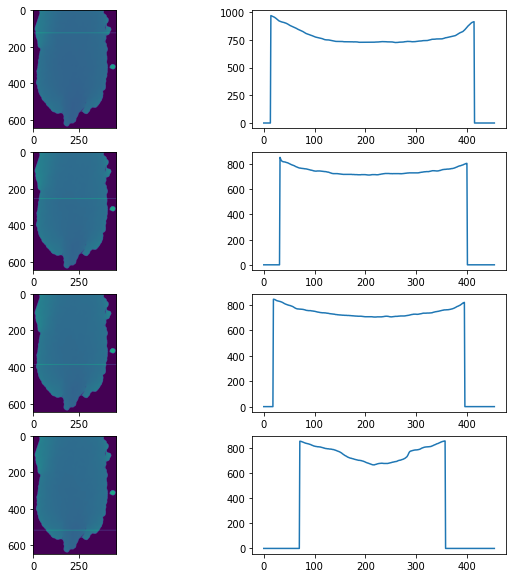

In [208]:
slice_vec = [int(length_depth/5), int(2*length_depth/5), int(3*length_depth/5), int(4*length_depth/5), length_depth]
j = 0
plt.figure(figsize=(10,10))
for i in range(1,9, 2):
    plt.subplot(4, 2, i)
    plt.imshow(masked_depth, cmap='gray')
    masked_line = np.zeros(np.shape(masked_depth))
    masked_line[slice_vec[j], 0:width_depth] = np.max(masked_depth)
    plt.imshow(masked_line+masked_depth)
    
    
    plt.subplot(4, 2, i+1)
    plt.plot(masked_depth[slice_vec[j], 0:width_depth])
    j+=1



#masked_depth_copy = masked_depth.copy()
# cv.line(masked_depth_copy, (0,width_depth), (y_coord, y_coord), (255, 0, 0), 1, cv.LINE_AA)

# cv.imshow('Path Shown', masked_depth_copy)

# k = cv.waitKey(0)
# if k == '27':
#     cv2.destroyAllWindows()

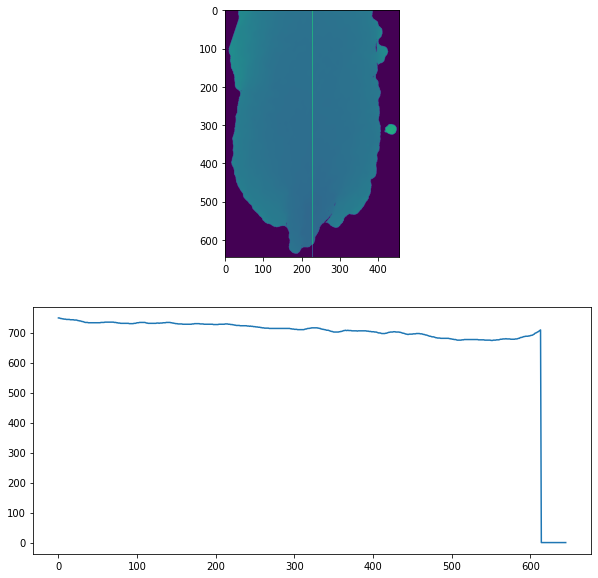

In [209]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
masked_line = np.zeros(np.shape(masked_depth))
masked_line[0:length_depth, int(width_depth/2)] = np.max(masked_depth)
plt.imshow(masked_line+masked_depth)

plt.subplot(2, 1, 2)
plt.plot(masked_depth[0:length_depth, int(width_depth/2)])

In [210]:
## Getting GLCM features
#from skimage.feature import graycomatrix, graycoprops
import skimage.feature.texture


def extract_texture_features(im, mask):
    im_1 = np.round((im/np.max(im))*31).astype(int)
    
    I_q_masked = im_1*np.where(mask >0 , 1, 0)
    print(np.max(I_q_masked))

  # print(np.max(I_q_masked))

    G = skimage.feature.greycomatrix(I_q_masked,distances=(1,2,3,4),angles=(0,np.pi/4,np.pi/2,3*np.pi/4),levels=np.max(I_q_masked)+1,symmetric=True,normed=False)#[0:-1, 0:-1, ::, ::]
    G_temp = np.zeros(np.shape(G))
    for d in range(0,4):
        for t in range(0,4):
            G_temp[:,:,d,t]=G[:,:,d,t]/G[:,:,d,t].sum()


    contrast = skimage.feature.greycoprops(G_temp, prop='contrast')
    d0_contrast_mean = np.mean(contrast[0, ::])
    d1_contrast_mean = np.mean(contrast[1, ::])
    d2_contrast_mean = np.mean(contrast[2, ::])
    d3_contrast_mean = np.mean(contrast[3, ::])
  
    d0_contrast_std = np.std(contrast[0,::])
    d1_contrast_std = np.std(contrast[1,::])
    d2_contrast_std = np.std(contrast[2,::])
    d3_contrast_std = np.std(contrast[3,::])

    correlation = skimage.feature.greycoprops(G_temp, prop='correlation')
    d0_correlation_mean = np.mean(correlation[0, ::])
    d1_correlation_mean = np.mean(correlation[1, ::])
    d2_correlation_mean = np.mean(correlation[2, ::])
    d3_correlation_mean = np.mean(correlation[3, ::])
  
    d0_correlation_std = np.std(correlation[0,::])
    d1_correlation_std = np.std(correlation[1,::])
    d2_correlation_std = np.std(correlation[2,::])
    d3_correlation_std = np.std(correlation[3,::])

    homogeneity = skimage.feature.greycoprops(G_temp, prop='homogeneity')
    d0_homogeneity_mean = np.mean(homogeneity[0, ::])
    d1_homogeneity_mean = np.mean(homogeneity[1, ::])
    d2_homogeneity_mean = np.mean(homogeneity[2, ::])
    d3_homogeneity_mean = np.mean(homogeneity[3, ::])
  
    d0_homogeneity_std = np.std(homogeneity[0,::])
    d1_homogeneity_std = np.std(homogeneity[1,::])
    d2_homogeneity_std = np.std(homogeneity[2,::])
    d3_homogeneity_std = np.std(homogeneity[3,::])

    energy = skimage.feature.greycoprops(G_temp, prop='energy')
    d0_energy_mean = np.mean(energy[0, ::])
    d1_energy_mean = np.mean(energy[1, ::])
    d2_energy_mean = np.mean(energy[2, ::])
    d3_energy_mean = np.mean(energy[3, ::])
  
    d0_energy_std = np.std(energy[0,::])
    d1_energy_std = np.std(energy[1,::])
    d2_energy_std = np.std(energy[2,::])
    d3_energy_std = np.std(energy[3,::])


    f = [d0_contrast_mean, d1_contrast_mean, d2_contrast_mean, d3_contrast_mean, d0_contrast_std, d1_contrast_std, d2_contrast_std, d3_contrast_std,
       d0_correlation_mean, d1_correlation_mean, d2_correlation_mean, d3_correlation_mean, d0_correlation_std, d1_correlation_std, d2_correlation_std, d3_correlation_std,
       d0_homogeneity_mean, d1_homogeneity_mean, d2_homogeneity_mean, d3_homogeneity_mean, d0_homogeneity_std, d1_homogeneity_std, d2_homogeneity_std, d3_homogeneity_std,
       d0_energy_mean, d1_energy_mean, d2_energy_mean, d3_energy_mean, d0_energy_std, d1_energy_std, d2_energy_std, d3_energy_std]

    fnames = ['d0_contrast_mean', 'd1_contrast_mean', 'd2_contrast_mean', 'd3_contrast_mean', 'd0_contrast_std', 'd1_contrast_std', 'd2_contrast_std', 'd3_contrast_std',
       'd0_correlation_mean', 'd1_correlation_mean', 'd2_correlation_mean', 'd3_correlation_mean', 'd0_correlation_std', 'd1_correlation_std', 'd2_correlation_std', 'd3_correlation_std',
       'd0_homogeneity_mean', 'd1_homogeneity_mean', 'd2_homogeneity_mean', 'd3_homogeneity_mean', 'd0_homogeneity_std', 'd1_homogeneity_std', 'd2_homogeneity_std', 'd3_homogeneity_std',
       'd0_energy_mean', 'd1_energy_mean', 'd2_energy_mean', 'd3_energy_mean', 'd0_energy_std', 'd1_energy_std', 'd2_energy_std', 'd3_energy_std']
    return f, fnames


f, fnames = extract_texture_features(masked_depth, b_cow)
print(f, fnames)

31
[2.3477550741669875, 3.2159476786708434, 5.298973612906538, 7.4176708139464, 0.5054638221696699, 0.8684969549998974, 1.1651436904031733, 1.587408634087661, 0.9850488374954067, 0.9794984278408188, 0.966112771132967, 0.9524073527534382, 0.003232676288957889, 0.005566023645523272, 0.007511701857558547, 0.010299004841130227, 0.9861089157562147, 0.9812842386654048, 0.96962277906395, 0.9579932024634021, 0.0031680997413927755, 0.005282065259588685, 0.007207365214391822, 0.009770025968318285, 0.4583288532155263, 0.4556861343096287, 0.44925870323209166, 0.4429043050916245, 0.0017192724176071422, 0.002764266818110011, 0.00374280511640671, 0.005108668171992799] ['d0_contrast_mean', 'd1_contrast_mean', 'd2_contrast_mean', 'd3_contrast_mean', 'd0_contrast_std', 'd1_contrast_std', 'd2_contrast_std', 'd3_contrast_std', 'd0_correlation_mean', 'd1_correlation_mean', 'd2_correlation_mean', 'd3_correlation_mean', 'd0_correlation_std', 'd1_correlation_std', 'd2_correlation_std', 'd3_correlation_std', '

In [211]:
def make_X_train(category_filepath):
    category = sorted(glob.glob(category_filepath))
    image_train = category[0:int(len(category)*0.9)]
    X_train = np.zeros((int(len(image_train)), 90 )) #90 will need to be changed to the number of features in the SVM
    y_train = []

    for images in range(int(len(image_train))):
        y_train.append(category_filepath[len('101_ObjectCategories/'):-2]) #BCS number, I'll have to edit the names of the images for this
        image_path = image_train[images]
        image = imageio.imread(image_path)
        try:
            mask = make_mask(image)
            X_train[images, 0:10]= extract_boundary_features(mask)[0]
            X_train[images, 10:17]= extract_hu_moments(mask)[0]
            X_train[images, 17:28]= regionprops_features(mask)[0]
            X_train[images, 28:60]= extract_texture_features(image, mask)[0]
        except IndexError: #???? I dont know why this was nessicary
            X_train[images, ::] = 0
    
  # for images in range(int(len(image_train))):
  #   if np.sum(X_train[images, ::]) == 0:
  #     X_train = np.delete(X_train, images, 0)
    return X_train, y_train


def make_X_test(category_filepath):
    category = sorted(glob.glob(category_filepath))

    image_test = category[int(len(category)*0.9):int(len(category))]
    X_test = np.zeros(( len(image_test), 90 ))
    y_test = []

    for images in range(len(image_test)):
        y_test.append(category_filepath[len('101_ObjectCategories/'):-2]) #change to bcs category
        image_path = image_test[images]
        image = imageio.imread(image_path)
        try:
            X_test[images, 0:10]= extract_boundary_features(mask)[0]
            X_test[images, 10:17]= extract_hu_moments(mask)[0]
            X_test[images, 17:28]= regionprops_features(mask)[0]
            X_test[images, 28:60]= extract_texture_features(image, mask)[0]
        except IndexError:
            X_train[images, ::] = 0
    
  # for images in range(len(image_test)):
  #   if np.sum(X_test[images, ::]) == 0:
  #     X_test = np.delete(X_test, images, 0)

    return X_test, y_test